<a href="https://colab.research.google.com/github/bavel4885/python_report/blob/main/yolov3_training_furits_MAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, sys 
from google.colab import drive 

drive.mount('/content/MyDrive')


Mounted at /content/MyDrive


In [ ]:
ls

content/  sample_data/


In [3]:
cd /content/MyDrive/MyDrive/CV_exprt

/content/MyDrive/MyDrive/CV_exprt


In [ ]:
ls

'01 tensorflow.ipynb'
'01 tensorflow.ipynb의 정답'
'02. keras .ipynb'
'03 Keras API 를 활용한 MNIST 데이터셋 분류 실습.ipynb'
'04 Keras API를 활용한 자동차 연비 예측 실습.ipynb'
'05. Fashion_minist 분류모델 .ipynb'
 CNN/
 fruit/


In [4]:
pip install numpy==1.19.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 5.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.0 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
cmdstanpy 1.0.4 requires numpy>=1.21, but you have numpy 1.19.0 which is incompatible.


config

In [5]:
# YOLO options
YOLO_DARKNET_WEIGHTS        = "./fruit/yolov3.weights"
YOLO_COCO_CLASSES           = "./fruit/coco.names"
YOLO_STRIDES                = [8, 16, 32]
YOLO_IOU_LOSS_THRESH        = 0.5
YOLO_ANCHOR_PER_SCALE       = 3
YOLO_MAX_BBOX_PER_SCALE     = 100
YOLO_INPUT_SIZE             = 416
YOLO_ANCHORS                = [[[10,  13], [16,   30], [33,   23]],
                               [[30,  61], [62,   45], [59,  119]],
                               [[116, 90], [156, 198], [373, 326]]]
# Train options
TRAIN_CLASSES               = "./fruit/fruits.names"
TRAIN_ANNOT_PATH            = "./fruit/train.txt"
TRAIN_BATCH_SIZE            = 4
TRAIN_INPUT_SIZE            = 416
TRAIN_DATA_AUG              = True
TRAIN_TRANSFER              = False
TRAIN_FROM_CHECKPOINT       = False #"./checkpoints_furits/yolov3_custom"

TRAIN_LR_INIT               = 1e-4
TRAIN_LR_END                = 1e-6
TRAIN_WARMUP_EPOCHS         = 2
TRAIN_EPOCHS                = 20

# TEST options
TEST_ANNOT_PATH             = "./fruit/test.txt"
TEST_BATCH_SIZE             = 4
TEST_INPUT_SIZE             = 416
TEST_DATA_AUG               = False



In [6]:
import cv2
import time
import random
import colorsys
import numpy as np
import tensorflow as tf

utils

In [7]:
def load_yolo_weights(model, weights_file):
    tf.keras.backend.clear_session() # used to reset layer names
    # load Darknet original weights to Keras model
    with open(weights_file, 'rb') as wf:
        major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

        j = 0
        for i in range(75):
            if i > 0:
                conv_layer_name = 'conv2d_%d' %i
            else:
                conv_layer_name = 'conv2d'
                
            if j > 0:
                bn_layer_name = 'batch_normalization_%d' %j
            else:
                bn_layer_name = 'batch_normalization'
            
            conv_layer = model.get_layer(conv_layer_name)
            filters = conv_layer.filters
            k_size = conv_layer.kernel_size[0]
            in_dim = conv_layer.input_shape[-1]

            if i not in [58, 66, 74]:
                # darknet weights: [beta, gamma, mean, variance]
                bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
                # tf weights: [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
                bn_layer = model.get_layer(bn_layer_name)
                j += 1
            else:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, k_size, k_size)
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

            if i not in [58, 66, 74]:
                conv_layer.set_weights([conv_weights])
                bn_layer.set_weights(bn_weights)
            else:
                conv_layer.set_weights([conv_weights, conv_bias])


In [8]:
def read_class_names(class_file_name):
    # loads class name from a file
    #print(class_file_name)
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

In [9]:
read_class_names(TRAIN_CLASSES)

{0: 'apple', 1: 'banana', 2: 'orange'}

In [10]:
def image_preprocess(image, target_size, gt_boxes=None):
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.
    print(gt_boxes)
    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes

In [11]:

def draw_bbox(image, bboxes, CLASSES=TRAIN_CLASSES, show_label=True, show_confidence = True, Text_colors=(255,255,0), rectangle_colors=''):   
    NUM_CLASS = read_class_names(CLASSES)
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    #print("hsv_tuples", hsv_tuples)
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = rectangle_colors if rectangle_colors != ''else colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        if bbox_thick < 1: bbox_thick = 1
        #print(image_h, image_w, bbox_thick)
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            score_str = f' {score:.2f}' if show_confidence else '' 
            label = f'{NUM_CLASS[class_ind]}' + score_str

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image

In [12]:
def bboxes_iou(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(float).eps)

    return ious


In [13]:

def nms(bboxes, iou_threshold, sigma=0.3):

    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]
        # Process 1: Determine whether the number of bounding boxes is greater than 0 
        while len(cls_bboxes) > 0:
            # Process 2: Select the bounding box with the highest score according to socre order A
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            # Process 3: Calculate this bounding box A and
            # Remain all iou of the bounding box and remove those bounding boxes whose iou value is higher than the threshold 
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=float)

            iou_mask = iou > iou_threshold
            weight[iou_mask] = 0.0

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

In [14]:
def postprocess_boxes(pred_bbox, original_image, input_size, score_threshold):
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # 1. (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # 2. (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = original_image.shape[:2]
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # 3. clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # 4. discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # 5. discard boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]
    #print(coors)

    #print(coors[0])
    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

In [15]:
def detect_image(YoloV3, image_path, output_path, input_size=416, show=False, CLASSES=TRAIN_CLASSES, score_threshold=0.3, iou_threshold=0.45, rectangle_colors=''):
    original_image      = cv2.imread(image_path)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    #original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    image_data = tf.expand_dims(image_data, 0)

    pred_bbox = YoloV3.predict(image_data)
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold)
    #xx=np.array(bboxes)
    #print(xx.shape)

    bboxes = nms(bboxes, iou_threshold)
    image = draw_bbox(original_image, bboxes, CLASSES=CLASSES, rectangle_colors=rectangle_colors)
    #cv2.imwrite('./output.jpg', image)
        
    return image

model

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization
from tensorflow.keras.regularizers import l2



STRIDES         = np.array(YOLO_STRIDES)
ANCHORS         = (np.array(YOLO_ANCHORS).T/STRIDES).T
IOU_LOSS_THRESH = YOLO_IOU_LOSS_THRESH

In [17]:
class BatchNormalization(BatchNormalization):
    # "Frozen state" and "inference mode" are two separate concepts.
    # `layer.trainable = False` is to freeze the layer, so the layer will use
    # stored moving `var` and `mean` in the "inference mode", and both `gama`
    # and `beta` will not be updated !
    def call(self, x, training=False):
        if not training:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True):
    if downsample:
        input_layer = ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
        padding = 'valid'
        strides = 2
    else:
        strides = 1
        padding = 'same'

    conv = Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides,
                  padding=padding, use_bias=not bn, kernel_regularizer=l2(0.0005),
                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                  bias_initializer=tf.constant_initializer(0.))(input_layer)
    if bn:
        conv = BatchNormalization()(conv)
    if activate == True:
        conv = LeakyReLU(alpha=0.1)(conv)

    return conv

def residual_block(input_layer, input_channel, filter_num1, filter_num2):
    short_cut = input_layer
    conv = convolutional(input_layer, filters_shape=(1, 1, input_channel, filter_num1))
    conv = convolutional(conv       , filters_shape=(3, 3, filter_num1,   filter_num2))

    residual_output = short_cut + conv
    return residual_output

def upsample(input_layer):
    return tf.image.resize(input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2), method='nearest')


def darknet53(input_data):
    input_data = convolutional(input_data, (3, 3,  3,  32))
    input_data = convolutional(input_data, (3, 3, 32,  64), downsample=True)

    for i in range(1):
        input_data = residual_block(input_data,  64,  32, 64)

    input_data = convolutional(input_data, (3, 3,  64, 128), downsample=True)

    for i in range(2):
        input_data = residual_block(input_data, 128,  64, 128)

    input_data = convolutional(input_data, (3, 3, 128, 256), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 256, 128, 256)

    route_1 = input_data
    input_data = convolutional(input_data, (3, 3, 256, 512), downsample=True)

    for i in range(8):
        input_data = residual_block(input_data, 512, 256, 512)

    route_2 = input_data
    input_data = convolutional(input_data, (3, 3, 512, 1024), downsample=True)

    for i in range(4):
        input_data = residual_block(input_data, 1024, 512, 1024)

    return route_1, route_2, input_data

def YOLOv3(input_layer, NUM_CLASS):
    # After the input layer enters the Darknet-53 network, we get three branches
    route_1, route_2, conv = darknet53(input_layer)
    # See the orange module (DBL) in the figure above, a total of 5 Subconvolution operation
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv = convolutional(conv, (3, 3,  512, 1024))
    conv = convolutional(conv, (1, 1, 1024,  512))
    conv_lobj_branch = convolutional(conv, (3, 3, 512, 1024))
    
    # conv_lbbox is used to predict large-sized objects , Shape = [None, 13, 13, 255] 
    conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1,  512,  256))
    # upsample here uses the nearest neighbor interpolation method, which has the advantage that the
    # upsampling process does not need to learn, thereby reducing the network parameter  
    conv = upsample(conv)

    conv = tf.concat([conv, route_2], axis=-1)
    conv = convolutional(conv, (1, 1, 768, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv_mobj_branch = convolutional(conv, (3, 3, 256, 512))

    # conv_mbbox is used to predict medium-sized objects, shape = [None, 26, 26, 255]
    conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1, 256, 128))
    conv = upsample(conv)

    conv = tf.concat([conv, route_1], axis=-1)
    conv = convolutional(conv, (1, 1, 384, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv_sobj_branch = convolutional(conv, (3, 3, 128, 256))
    
    # conv_sbbox is used to predict small size objects, shape = [None, 52, 52, 255]
    conv_sbbox = convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)
        
    return [conv_sbbox, conv_mbbox, conv_lbbox]

def Create_Yolov3(input_size=416, channels=3, training=False, CLASSES=TRAIN_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    input_layer  = Input([input_size, input_size, channels])

    conv_tensors = YOLOv3(input_layer, NUM_CLASS)

    output_tensors = []
    for i, conv_tensor in enumerate(conv_tensors):
        pred_tensor = decode(conv_tensor, NUM_CLASS, i)
        if training: output_tensors.append(conv_tensor)
        output_tensors.append(pred_tensor)

    YoloV3 = tf.keras.Model(input_layer, output_tensors)
    return YoloV3

def decode(conv_output, NUM_CLASS, i=0):
    # where i = 0, 1 or 2 to correspond to the three grid scales  
    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy = conv_output[:, :, :, :, 0:2] # offset of center position     
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4] # Prediction box length and width offset
    conv_raw_conf = conv_output[:, :, :, :, 4:5] # confidence of the prediction box
    conv_raw_prob = conv_output[:, :, :, :, 5: ] # category probability of the prediction box 

    # next need Draw the grid. Where output_size is equal to 13, 26 or 52  
    y = tf.range(output_size, dtype=tf.int32)
    y = tf.expand_dims(y, -1)
    y = tf.tile(y, [1, output_size])
    x = tf.range(output_size,dtype=tf.int32)
    x = tf.expand_dims(x, 0)
    x = tf.tile(x, [output_size, 1])

    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    # Calculate the center position of the prediction box:
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    # Calculate the length and width of the prediction box:
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]

    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf) # object box calculates the predicted confidence
    pred_prob = tf.sigmoid(conv_raw_prob) # calculating the predicted probability category box object

    # calculating the predicted probability category box object
    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

def bbox_iou(boxes1, boxes2):
    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area

    return 1.0 * inter_area / union_area

def bbox_giou(boxes1, boxes2):
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    iou = inter_area / union_area

    enclose_left_up = tf.minimum(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = tf.maximum(boxes1[..., 2:], boxes2[..., 2:])
    enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)
    enclose_area = enclose[..., 0] * enclose[..., 1]
    giou = iou - 1.0 * (enclose_area - union_area) / enclose_area

    return giou


def compute_loss(pred, conv, label, bboxes, i=0, CLASSES=TRAIN_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    conv_shape  = tf.shape(conv)
    batch_size  = conv_shape[0]
    output_size = conv_shape[1]
    input_size  = STRIDES[i] * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_conf = conv[:, :, :, :, 4:5]
    conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh     = pred[:, :, :, :, 0:4]
    pred_conf     = pred[:, :, :, :, 4:5]

    label_xywh    = label[:, :, :, :, 0:4]
    respond_bbox  = label[:, :, :, :, 4:5]
    label_prob    = label[:, :, :, :, 5:]

    giou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)
    input_size = tf.cast(input_size, tf.float32)

    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    giou_loss = respond_bbox * bbox_loss_scale * (1- giou)

    iou = bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)

    respond_bgd = (1.0 - respond_bbox) * tf.cast( max_iou < IOU_LOSS_THRESH, tf.float32)

    conf_focal = tf.pow(respond_bbox - pred_conf, 2)

    conf_loss = conf_focal * (
            respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
            +
            respond_bgd * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
    )

    prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1,2,3,4]))
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1,2,3,4]))
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1,2,3,4]))

    return giou_loss, conf_loss, prob_loss
def calculateAveragePrecison(rec,prec):
  mrec = [0] + [e for e in rec] + [1]
  mpre = [0] + [e for e in prec] + [0]

  for i in range(len(mpre)-1,0,-1):
    mpre[i-1] = max(mpre[i-1], mpre[i])

    ii = []

    for i in range(len(mrec)-1):
      if mrec[1:][i]  != mrec[0:1][i]:
        ii.apend(i+1)
    ap = 0
    for i in ii:
      ap = ap + np.sum((mrec[i] - mrec[i-1] + mpre[i]))
    return [ap, mpre[0:len(mpre)-1], mrec[0:len(mpre)-1], ii]
  def ElevenPointinterpolatedAP(rec,prec):

    mrec = [e for e in rec]
    mpre = [e for e in prec]

    recallValues = np.linspace( 0,1,11)
    recallValues = list(recallValues[::-1])
    rhointerp, recallVaild = [], []

    for r in recallValues :
      argGreaterRecalls = np.argwhere(mrec[:] >= r)
      pmax = 0
      
      if argGreaterRecalls.size != 0:
        pmax = max(mpre[argGreaterRecalls.min():])

      recallVaild.append(r)
      rhointerp.append(pmax)
    ap = sum(rhointerp) / 11

    return [ap, rhointerp, recallValues, None]
  def AP(detections, groundtruths, classes, IOUThreshold = 0.3, method = 'AP'):
    result = []
    for c in classes:
      dects = [d for d in detections if d[0] == c]
      gts = [g for g in groundtruths if g[0] == c]

      npos = len(gts)

      dects = sorted(dects, key = lambda conf : conf[2], reverse = True)

      TP = np.zeros(len(dects))
      FP = np.zeros(len(dects))

      det = Counter(cc[0] for cc in gts)

      for key, val in det.items():
        det[key] = np.zeros(val)
      for d in range(len(dects)):

        gt = [gt for gt in gts if gt[0] == dects[d][0]]
        iouMax = 0

        for j in range(len(gt)):
          iou1 = iou(dects[d][3], gt[j][3])
          if iou1 >iouMax:
            iouMax = iou1
            jmax = j
        if iouMax >= IOUThreshold:
          if det [dects[d][0]][jmax] == 0:
            TP[d] = 1
            det[dects[d][0][jmax]] = 1
          else:
            FP[d] = 1
        acc_FP = np.cumsum(FP)
        acc_TP = np.cumsum(TP)
        rec = acc_TP / npos
        prec = np.divide(acc_TP, (acc_FP + acc_TP))
        if method == "AP":
          [ap,mpre,mrecm,ii] = calculateAveragePrecison(rec,prec)
        else:
          [ap,mpre,mrecm,_] = ElevenPointinterpolatedAP(rec,prec)

          r = {
              'class' : c,
              'precision' : prec,
               'recall' : rec,
               'AP' : ap,
               'interpolated precision' : mpre,
               'interpolated recall' : mrec,
               'total positives' : npos,
               'total TP' : np.sum(TP),
               'total FP' : np.sum(FP)
          }

          result.append(r)
        return result

In [18]:

import os
import cv2
import random
import numpy as np
import tensorflow as tf



class Dataset(object):
    # Dataset preprocess implementation
    def __init__(self, dataset_type):
        self.annot_path  = TRAIN_ANNOT_PATH if dataset_type == 'train' else TEST_ANNOT_PATH
        self.input_sizes = TRAIN_INPUT_SIZE if dataset_type == 'train' else TEST_INPUT_SIZE
        self.batch_size  = TRAIN_BATCH_SIZE if dataset_type == 'train' else TEST_BATCH_SIZE
        self.data_aug    = TRAIN_DATA_AUG   if dataset_type == 'train' else TEST_DATA_AUG

        self.train_input_sizes = TRAIN_INPUT_SIZE
        self.strides = np.array(YOLO_STRIDES)
        self.classes = read_class_names(TRAIN_CLASSES)
        self.num_classes = len(self.classes)
        self.anchors = (np.array(YOLO_ANCHORS).T/self.strides).T
        self.anchor_per_scale = YOLO_ANCHOR_PER_SCALE
        self.max_bbox_per_scale = YOLO_MAX_BBOX_PER_SCALE

        self.annotations = self.load_annotations(dataset_type)
        self.num_samples = len(self.annotations)
        self.num_batchs = int(np.ceil(self.num_samples / self.batch_size))
        self.batch_count = 0


    def load_annotations(self, dataset_type):
        final_annotations = []
        with open(self.annot_path, 'r') as f:
            txt = f.readlines()
            annotations = [line.strip() for line in txt if len(line.strip().split()[1:]) != 0]
        np.random.shuffle(annotations)
        
        for annotation in annotations:
            # fully parse annotations
            line = annotation.split()
            image_path, index = "", 1
            for i, one_line in enumerate(line):
                if not one_line.replace(",","").isnumeric():
                    if image_path != "": image_path += " "
                    image_path += one_line
                else:
                    index = i
                    break
            if not os.path.exists(image_path):
                raise KeyError("%s does not exist ... " %image_path)

            final_annotations.append([image_path, line[index:]])

        return final_annotations

    def __iter__(self):
        return self

    def __next__(self):
        with tf.device('/cpu:0'):
            self.train_input_size = random.choice([self.train_input_sizes])
            self.train_output_sizes = self.train_input_size // self.strides

            batch_image = np.zeros((self.batch_size, self.train_input_size, self.train_input_size, 3), dtype=np.float32)

            batch_label_sbbox = np.zeros((self.batch_size, self.train_output_sizes[0], self.train_output_sizes[0],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)
            batch_label_mbbox = np.zeros((self.batch_size, self.train_output_sizes[1], self.train_output_sizes[1],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)
            batch_label_lbbox = np.zeros((self.batch_size, self.train_output_sizes[2], self.train_output_sizes[2],
                                          self.anchor_per_scale, 5 + self.num_classes), dtype=np.float32)

            batch_sbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)
            batch_mbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)
            batch_lbboxes = np.zeros((self.batch_size, self.max_bbox_per_scale, 4), dtype=np.float32)

            num = 0
            if self.batch_count < self.num_batchs:
                while num < self.batch_size:
                    index = self.batch_count * self.batch_size + num
                    if index >= self.num_samples: index -= self.num_samples
                    annotation = self.annotations[index]
                    image, bboxes = self.parse_annotation(annotation)
                    label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes = self.preprocess_true_boxes(bboxes)

                    batch_image[num, :, :, :] = image
                    batch_label_sbbox[num, :, :, :, :] = label_sbbox
                    batch_label_mbbox[num, :, :, :, :] = label_mbbox
                    batch_label_lbbox[num, :, :, :, :] = label_lbbox
                    batch_sbboxes[num, :, :] = sbboxes
                    batch_mbboxes[num, :, :] = mbboxes
                    batch_lbboxes[num, :, :] = lbboxes
                    num += 1
                self.batch_count += 1
                batch_smaller_target = batch_label_sbbox, batch_sbboxes
                batch_medium_target  = batch_label_mbbox, batch_mbboxes
                batch_larger_target  = batch_label_lbbox, batch_lbboxes

                return batch_image, (batch_smaller_target, batch_medium_target, batch_larger_target)
            else:
                self.batch_count = 0
                np.random.shuffle(self.annotations)
                raise StopIteration

    def random_horizontal_flip(self, image, bboxes):
        if random.random() < 0.5:
            _, w, _ = image.shape
            image = image[:, ::-1, :]
            bboxes[:, [0,2]] = w - bboxes[:, [2,0]]

        return image, bboxes

    def random_crop(self, image, bboxes):
        if random.random() < 0.5:
            h, w, _ = image.shape
            max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

            max_l_trans = max_bbox[0]
            max_u_trans = max_bbox[1]
            max_r_trans = w - max_bbox[2]
            max_d_trans = h - max_bbox[3]

            crop_xmin = max(0, int(max_bbox[0] - random.uniform(0, max_l_trans)))
            crop_ymin = max(0, int(max_bbox[1] - random.uniform(0, max_u_trans)))
            crop_xmax = max(w, int(max_bbox[2] + random.uniform(0, max_r_trans)))
            crop_ymax = max(h, int(max_bbox[3] + random.uniform(0, max_d_trans)))

            image = image[crop_ymin : crop_ymax, crop_xmin : crop_xmax]

            bboxes[:, [0, 2]] = bboxes[:, [0, 2]] - crop_xmin
            bboxes[:, [1, 3]] = bboxes[:, [1, 3]] - crop_ymin

        return image, bboxes

    def random_translate(self, image, bboxes):
        if random.random() < 0.5:
            h, w, _ = image.shape
            max_bbox = np.concatenate([np.min(bboxes[:, 0:2], axis=0), np.max(bboxes[:, 2:4], axis=0)], axis=-1)

            max_l_trans = max_bbox[0]
            max_u_trans = max_bbox[1]
            max_r_trans = w - max_bbox[2]
            max_d_trans = h - max_bbox[3]

            tx = random.uniform(-(max_l_trans - 1), (max_r_trans - 1))
            ty = random.uniform(-(max_u_trans - 1), (max_d_trans - 1))

            M = np.array([[1, 0, tx], [0, 1, ty]])
            image = cv2.warpAffine(image, M, (w, h))

            bboxes[:, [0, 2]] = bboxes[:, [0, 2]] + tx
            bboxes[:, [1, 3]] = bboxes[:, [1, 3]] + ty

        return image, bboxes

    def parse_annotation(self, annotation):

        image_path = annotation[0]
        image = cv2.imread(image_path)
            
        bboxes = np.array([list(map(int, box.split(','))) for box in annotation[1]])

        if self.data_aug:
            image, bboxes = self.random_horizontal_flip(np.copy(image), np.copy(bboxes))
            image, bboxes = self.random_crop(np.copy(image), np.copy(bboxes))
            image, bboxes = self.random_translate(np.copy(image), np.copy(bboxes))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image, bboxes = image_preprocess(np.copy(image), [self.train_input_size, self.train_input_size], np.copy(bboxes))
        return image, bboxes

    def preprocess_true_boxes(self, bboxes):
        label = [np.zeros((self.train_output_sizes[i], self.train_output_sizes[i], self.anchor_per_scale,
                           5 + self.num_classes)) for i in range(3)]
        bboxes_xywh = [np.zeros((self.max_bbox_per_scale, 4)) for _ in range(3)]
        bbox_count = np.zeros((3,))

        for bbox in bboxes:
            bbox_coor = bbox[:4]
            bbox_class_ind = bbox[4]

            onehot = np.zeros(self.num_classes, dtype=np.float64)
            onehot[bbox_class_ind] = 1.0
            uniform_distribution = np.full(self.num_classes, 1.0 / self.num_classes)
            deta = 0.01
            smooth_onehot = onehot * (1 - deta) + deta * uniform_distribution

            bbox_xywh = np.concatenate([(bbox_coor[2:] + bbox_coor[:2]) * 0.5, bbox_coor[2:] - bbox_coor[:2]], axis=-1)
            bbox_xywh_scaled = 1.0 * bbox_xywh[np.newaxis, :] / self.strides[:, np.newaxis]

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((self.anchor_per_scale, 4))
                anchors_xywh[:, 0:2] = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                anchors_xywh[:, 2:4] = self.anchors[i]

                iou_scale = bbox_iou(bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh)
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32)

                    label[i][yind, xind, iou_mask, :] = 0
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:] = smooth_onehot

                    bbox_ind = int(bbox_count[i] % self.max_bbox_per_scale)
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / self.anchor_per_scale)
                best_anchor = int(best_anchor_ind % self.anchor_per_scale)
                xind, yind = np.floor(bbox_xywh_scaled[best_detect, 0:2]).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, :] = 0
                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                label[best_detect][yind, xind, best_anchor, 5:] = smooth_onehot
                
                bbox_ind = int(bbox_count[best_detect] % self.max_bbox_per_scale)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                bbox_count[best_detect] += 1

        label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh
        return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

    def __len__(self):
        return self.num_batchs


In [19]:
trainset = Dataset('train')
steps_per_epoch = len(trainset)
steps_per_epoch

60

training

In [20]:


import os
import shutil
import numpy as np
import tensorflow as tf

global TRAIN_FROM_CHECKPOINT
input_size = YOLO_INPUT_SIZE
Darknet_weights = YOLO_DARKNET_WEIGHTS


save_best_only = True # saves only best model according validation loss
save_checkpoints = False # saves all best validated checkpoints in training process (may require a lot disk space)


trainset = Dataset('train')
testset = Dataset('test')

steps_per_epoch = len(trainset)
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
warmup_steps = TRAIN_WARMUP_EPOCHS * steps_per_epoch
total_steps = TRAIN_EPOCHS * steps_per_epoch

if TRAIN_TRANSFER:
    Darknet = Create_Yolov3(input_size=input_size)
    load_yolo_weights(Darknet, Darknet_weights) # use darknet weights

yolo = Create_Yolov3(input_size=input_size, training=True, CLASSES=TRAIN_CLASSES)

#TRAIN_FROM_CHECKPOINT = False
if TRAIN_FROM_CHECKPOINT:
    yolo.load_weights(TRAIN_FROM_CHECKPOINT)

## transfer && Not use checkpoint
if TRAIN_TRANSFER and not TRAIN_FROM_CHECKPOINT:
    for i, l in enumerate(Darknet.layers):
        layer_weights = l.get_weights()
        if layer_weights != []:
            try:
                yolo.layers[i].set_weights(layer_weights)
            except:
                print("skipping", yolo.layers[i].name)

optimizer = tf.keras.optimizers.Adam()

def train_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=True)
        giou_loss=conf_loss=prob_loss=0
        # optimizing process
        for i in range(3):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=TRAIN_CLASSES)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]
        total_loss = giou_loss + conf_loss + prob_loss
        gradients = tape.gradient(total_loss, yolo.trainable_variables)
        optimizer.apply_gradients(zip(gradients, yolo.trainable_variables))


        # update learning rate
        global_steps.assign_add(1)
        if global_steps < warmup_steps:# and not TRAIN_TRANSFER:
            lr = global_steps / warmup_steps * TRAIN_LR_INIT
        else:
            lr = TRAIN_LR_END + 0.5 * (TRAIN_LR_INIT - TRAIN_LR_END)*(
                (1 + tf.cos((global_steps - warmup_steps) / (total_steps - warmup_steps) * np.pi)))
        optimizer.lr.assign(lr.numpy())

    return global_steps.numpy(), optimizer.lr.numpy(), giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()



def validate_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=False)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        for i in range(3):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=TRAIN_CLASSES)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss
        
    return giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()


best_val_loss = 1000 # should be large at start


for epoch in range(TRAIN_EPOCHS):
    for image_data, target in trainset:
        results = train_step(image_data, target)
        cur_step = results[0]%steps_per_epoch
        print("epoch:{:2.0f} step:{:5.0f}/{}, lr:{:.6f}, giou_loss:{:7.2f}, conf_loss:{:7.2f}, prob_loss:{:7.2f}, total_loss:{:7.2f}"
                  .format(epoch, cur_step, steps_per_epoch, results[1], results[2], results[3], results[4], results[5]))
        
    count, giou_val, conf_val, prob_val, total_val = 0., 0, 0, 0, 0
    for image_data, target in testset:
        results = validate_step(image_data, target)
        count += 1
        giou_val += results[0]
        conf_val += results[1]
        prob_val += results[2]
        total_val += results[3]

        
    print("\n\ngiou_val_loss:{:7.2f}, conf_val_loss:{:7.2f}, prob_val_loss:{:7.2f}, total_val_loss:{:7.2f}\n\n".
          format(giou_val/count, conf_val/count, prob_val/count, total_val/count))

    if save_best_only and best_val_loss > total_val/count: 
        yolo.save_weights("./chkpt_fruits/yolov3_custom")
        best_val_loss = total_val/count



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[[155   8 340 100   1 305  81 489 175   1]]
[[ 65  18 693 192   1 120 106 707 416   1 279  14 720 308   1]]
[[ 95  63 597 266   1]]
epoch: 8 step:    2/60, lr:0.000075, giou_loss:   1.93, conf_loss:  37.87, prob_loss:   2.83, total_loss:  42.64
[[263  11 637 389   2 209 134 866 348   1 263 267 849 551   1]]
[[149  18 485 381   2]]
[[ 72   7 434 334   2]]
[[137 176 500 665   1]]
epoch: 8 step:    3/60, lr:0.000075, giou_loss:   1.05, conf_loss:  37.85, prob_loss:   3.06, total_loss:  41.96
[[149  26 605 395   2]]
[[ 61   3 216 150   0]]
[[ 13  13 269 243   2  24   1 239 187   2 401  47 600 297   2 205  25 417
  209   2 302 272 566 398   2]]
[[ 111  204  844  979    2  580   21 1273  753    2]]
epoch: 8 step:    4/60, lr:0.000075, giou_loss:   1.02, conf_loss:  36.92, prob_loss:   3.70, total_loss:  41.63
[[  7 105 476 439   0   3  40 475 439   0]]
[[ 27  13 314 299   0]]
[[ 99  83 458 416   1 186  39 624 382   1 205   8 670 226   1]]
[[190  77 379 271

In [21]:
best_val_loss

26.000934982299803

test

None


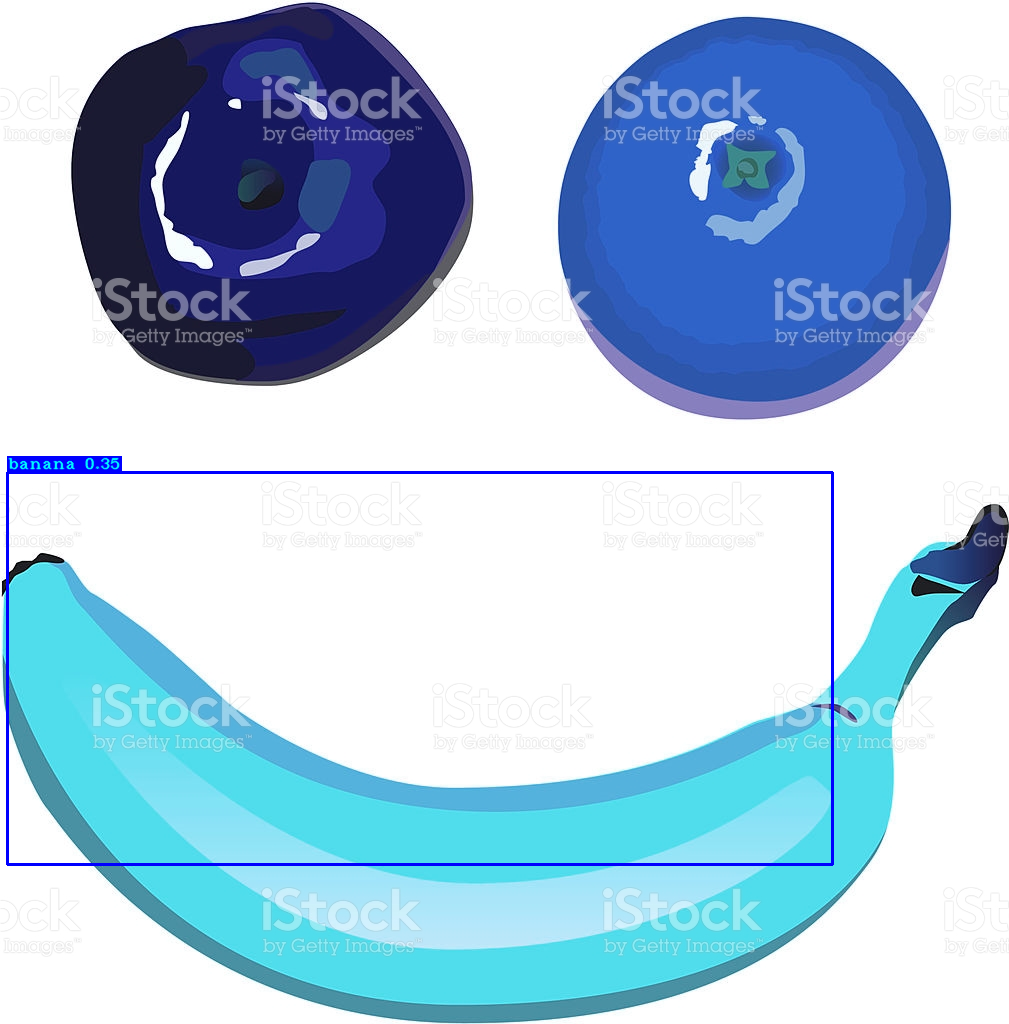

In [22]:

import os
import cv2
import numpy as np
import random
import time
import tensorflow as tf
from google.colab.patches import cv2_imshow


YOLO_INPUT_SIZE = 416
input_size=YOLO_INPUT_SIZE



image_path ="./fruit/test/mixed_22.jpg" #image_info[0]

yolo = Create_Yolov3(input_size=input_size, CLASSES=TRAIN_CLASSES)
yolo.load_weights("./chkpt_fruits/yolov3_custom")



img = detect_image(yolo, image_path, "", input_size=input_size, show=True, CLASSES=TRAIN_CLASSES, rectangle_colors=(255,0,0))
cv2_imshow(img)

In [23]:
image_path

'./fruit/test/mixed_22.jpg'